In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
!pip install -q keras numpy sklearn h5py matplotlib

In [4]:
# Import all relevant libraries
import warnings
def fxn(): 
	warnings.warn("deprecated",DeprecationWarning)

with warnings.catch_warnings( ):
    warnings.simplefilter("ignore")
    fxn( )

# Keras imports
import keras
from keras.models import Sequential
from keras.layers import Permute, Flatten, Softmax, Dense, Conv1D, Conv2D, Conv2DTranspose, AveragePooling2D, Activation, Reshape, Dropout, BatchNormalization, MaxPooling2D, LSTM, GRU

# Other
import numpy as np
import h5py
import sklearn
from sklearn.model_selection import StratifiedKFold, train_test_split, StratifiedShuffleSplit
from sklearn import preprocessing
import matplotlib.pyplot as plt

# random seed for reproducability
np.random.seed(1)

Using TensorFlow backend.


In [0]:
# Load data from specific trial
def get_trial(trial_num):    
    trial = h5py.File('drive/ECE239/data/A0' + str(trial_num) + 'T_slice.mat', 'r')
    X = np.copy(trial['image'])
    y = np.copy(trial['type'])
    y = y[0,0:X.shape[0]:1]
    y = np.asarray(y, dtype=np.int32)
    y -= 769                            # shift class labels to [0-3]
    X = np.nan_to_num(X)[:, :22, :]     # remove EOG channels
    return X, y

def get_all_trials():
    X_total = np.concatenate([get_trial(trial_num)[0] for trial_num in range(1, 9)], axis=0)
    y_total = np.concatenate([get_trial(trial_num)[1] for trial_num in range(1, 9)], axis=0)
    return X_total, y_total

def stratified_train_test_split(X, y, k, num_trials):
    ''' Returns a stratified train/test split, for k number of splits.
    Return value is in the form [(train indices, test indices), ... for k folds ]
    '''
    sss = StratifiedShuffleSplit(n_splits=k, test_size=50*num_trials)
    return sss.split(X, y)
  
def generate_sliding_window(X, y, window_size):
    new_X = None
    new_y = None
    for i in range(0, int(X.shape[0])):
      for j in range(0, int(X.shape[2])-window_size+1, window_size//2):
          temp_x = np.array(X[i, :, j:j+window_size]).reshape((1, -1, window_size))
          temp_y = np.array(y[i])
          if type(new_X) != type(np.array([[],[]])):
              new_X = temp_x
              new_y = temp_y
          else:
              new_X = np.concatenate([new_X, temp_x], axis=0)
              new_y = np.append(new_y, temp_y)
    return new_X, new_y

In [81]:
num_folds = 5
window_size = 500

# Get the data from one person
X, y = get_trial(1)
num_trials = 1

x_shape = X.shape
y_shape = y.shape

print(x_shape)

# generate sliding window data
X, y = generate_sliding_window(X, y, window_size)
print(X.shape)

# Get the data from all the people
# X, y = get_all_trials()
# num_trials = 9

# 0 mean and unit variance
temp = np.reshape(X, (X.shape[0], -1))
X = np.reshape(preprocessing.scale(temp), X.shape)

# Generate train/test split
y_cat = keras.utils.to_categorical(y, num_classes=4)
tt_splits = stratified_train_test_split(X, y, num_folds, num_trials)

print(tt_splits)

# The data for each trial is of the shape (288, 22, 1000)
#   There are 288 samples per trial (12 of each class per "run", 4 classes, 6 "runs" 
#                                   at different time periods of the day)
#   There are 22 electrodes from the EEG (represents spatial aspect of the signals)
#   There are 1000 time units (4 seconds of data, sampled at 250Hz). The first 250 units
#                                   are when no movement occurs (but the cue is heard) and
#                                   the next 750 units are when the movement occurs
# The labels for each trial belong in one of 4 classes
#   0 - left
#   1 - right
#   2 - foot
#   3 - tongue

# Set training params for NN
batch_size = 32
val_split = 0.2
num_epochs = 5

(288, 22, 1000)
(864, 22, 500)
<generator object BaseShuffleSplit.split at 0x7f4895cacd00>


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_3 (Permute)          (None, 500, 22)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 476, 64)           35264     
_________________________________________________________________
dropout_3 (Dropout)          (None, 476, 64)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 452, 64)           102464    
_________________________________________________________________
dropout_4 (Dropout)          (None, 452, 64)           0         
_________________________________________________________________
permute_4 (Permute)          (None, 64, 452)           0         
_________________________________________________________________
gru_3 (GRU)                  (None, 64, 32)            46560     
__________

651/651 [==============================] - 4s 6ms/step - loss: 1.3827 - acc: 0.2980 - val_loss: 1.3930 - val_acc: 0.2699
Epoch 4/30
651/651 [==============================] - 4s 6ms/step - loss: 1.3575 - acc: 0.3164 - val_loss: 1.4006 - val_acc: 0.3067
Epoch 5/30
651/651 [==============================] - 4s 6ms/step - loss: 1.3386 - acc: 0.3487 - val_loss: 1.3997 - val_acc: 0.3067
Epoch 6/30
651/651 [==============================] - 4s 6ms/step - loss: 1.3457 - acc: 0.3472 - val_loss: 1.4000 - val_acc: 0.2761
Epoch 7/30
651/651 [==============================] - 4s 6ms/step - loss: 1.3203 - acc: 0.4071 - val_loss: 1.4014 - val_acc: 0.2945
Epoch 8/30
651/651 [==============================] - 4s 6ms/step - loss: 1.2968 - acc: 0.4301 - val_loss: 1.4064 - val_acc: 0.2822
Epoch 9/30
651/651 [==============================] - 4s 6ms/step - loss: 1.2818 - acc: 0.4240 - val_loss: 1.4185 - val_acc: 0.2822
Epoch 10/30
651/651 [==============================] - 4s 6ms/step - loss: 1.2754 - acc

651/651 [==============================] - 4s 6ms/step - loss: 1.2683 - acc: 0.4332 - val_loss: 1.4315 - val_acc: 0.2577
Epoch 12/30
651/651 [==============================] - 4s 6ms/step - loss: 1.2302 - acc: 0.4808 - val_loss: 1.4338 - val_acc: 0.2699
Epoch 13/30
651/651 [==============================] - 4s 6ms/step - loss: 1.2137 - acc: 0.4839 - val_loss: 1.4403 - val_acc: 0.2822
Epoch 14/30
651/651 [==============================] - 4s 6ms/step - loss: 1.2195 - acc: 0.4962 - val_loss: 1.4384 - val_acc: 0.2822
Epoch 15/30
651/651 [==============================] - 4s 6ms/step - loss: 1.2010 - acc: 0.4869 - val_loss: 1.4451 - val_acc: 0.2945
Epoch 16/30
651/651 [==============================] - 4s 6ms/step - loss: 1.1975 - acc: 0.5084 - val_loss: 1.4529 - val_acc: 0.2945
Epoch 17/30
651/651 [==============================] - 4s 6ms/step - loss: 1.1597 - acc: 0.5238 - val_loss: 1.4611 - val_acc: 0.2883
Epoch 18/30
651/651 [==============================] - 4s 6ms/step - loss: 1.1531

651/651 [==============================] - 4s 6ms/step - loss: 1.1324 - acc: 0.5591 - val_loss: 1.4932 - val_acc: 0.2883
Epoch 20/30
651/651 [==============================] - 4s 6ms/step - loss: 1.0934 - acc: 0.5837 - val_loss: 1.5081 - val_acc: 0.2699
Epoch 21/30
651/651 [==============================] - 4s 6ms/step - loss: 1.0832 - acc: 0.5714 - val_loss: 1.5180 - val_acc: 0.2699
Epoch 22/30
651/651 [==============================] - 4s 6ms/step - loss: 1.0652 - acc: 0.5991 - val_loss: 1.5360 - val_acc: 0.2945
Epoch 23/30
651/651 [==============================] - 4s 6ms/step - loss: 1.0444 - acc: 0.5914 - val_loss: 1.5274 - val_acc: 0.2883
Epoch 24/30
651/651 [==============================] - 4s 6ms/step - loss: 1.0331 - acc: 0.6068 - val_loss: 1.5337 - val_acc: 0.3067
Epoch 25/30
651/651 [==============================] - 4s 6ms/step - loss: 1.0066 - acc: 0.6221 - val_loss: 1.5357 - val_acc: 0.2822
Epoch 26/30
651/651 [==============================] - 4s 6ms/step - loss: 0.9882

651/651 [==============================] - 4s 6ms/step - loss: 0.9865 - acc: 0.6237 - val_loss: 1.5727 - val_acc: 0.3313
Epoch 28/30
651/651 [==============================] - 4s 6ms/step - loss: 0.9753 - acc: 0.6344 - val_loss: 1.5904 - val_acc: 0.2883
Epoch 29/30
651/651 [==============================] - 4s 6ms/step - loss: 0.9424 - acc: 0.6621 - val_loss: 1.5887 - val_acc: 0.2883
Epoch 30/30
651/651 [==============================] - 4s 6ms/step - loss: 0.9145 - acc: 0.6544 - val_loss: 1.5888 - val_acc: 0.2822


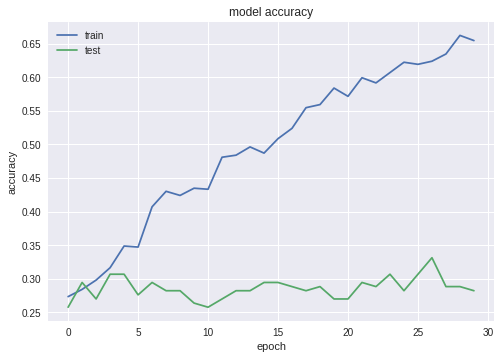

50/50 [==============================] - 0s 2ms/step
[1.4325513648986816, 0.3000000047683716]
0.3000000047683716


In [83]:
num_epochs = 30

# Create GRU model

# GRU uses less params than LSTM, for faster training
# Simple GRU model with stacked GRU layers (inspiration from NLP) - 3 layers, with dropout
# GRU layer accepts data in the form (samples, timesteps, features)

def make_GRU():
    # input is of the form: (sample, spatial, temporal)
    model = Sequential()
    model.add(Permute((2, 1), input_shape=(22, 500)))
    
    model.add(Conv1D(filters = 64, kernel_size = 25, activation = 'elu'))
    model.add(Dropout(0.4))
    model.add(Conv1D(filters = 64, kernel_size = 25, activation = 'elu'))
    model.add(Dropout(0.4))
    
    model.add(Permute((2, 1)))
    
    # GRU layers
    model.add(GRU(32, return_sequences=True))
    model.add(GRU(32, return_sequences=True))
    
    # Dense layers
    model.add(Flatten())
    model.add(Dense(units=4, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='SGD',
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

# make_GRU()
  
avg_acc = 0
for train_idx, test_idx in tt_splits:
    X_train = X[train_idx]
    y_train = y_cat[train_idx]
    X_test = X[test_idx]
    y_test = y_cat[test_idx]
    
    model = make_GRU()
    
    history = model.fit(X_train, y_train, validation_split=val_split, epochs=num_epochs, batch_size=batch_size)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    metrics = model.evaluate(X_test, y_test, batch_size=batch_size)
    avg_acc += metrics[1]
    print(metrics)
    break

print(avg_acc)

In [84]:
num_folds = 5
window_size = 200

# Get the data from one person
X, y = get_trial(1)
num_trials = 1

x_shape = X.shape
y_shape = y.shape

print(x_shape)

# generate sliding window data
X, y = generate_sliding_window(X, y, window_size)
print(X.shape)

# Get the data from all the people
# X, y = get_all_trials()
# num_trials = 9

# 0 mean and unit variance
temp = np.reshape(X, (X.shape[0], -1))
X = np.reshape(preprocessing.scale(temp), X.shape)

# Generate train/test split
y_cat = keras.utils.to_categorical(y, num_classes=4)
tt_splits = stratified_train_test_split(X, y, num_folds, num_trials)

print(tt_splits)

# The data for each trial is of the shape (288, 22, 1000)
#   There are 288 samples per trial (12 of each class per "run", 4 classes, 6 "runs" 
#                                   at different time periods of the day)
#   There are 22 electrodes from the EEG (represents spatial aspect of the signals)
#   There are 1000 time units (4 seconds of data, sampled at 250Hz). The first 250 units
#                                   are when no movement occurs (but the cue is heard) and
#                                   the next 750 units are when the movement occurs
# The labels for each trial belong in one of 4 classes
#   0 - left
#   1 - right
#   2 - foot
#   3 - tongue

# Set training params for NN
batch_size = 32
val_split = 0.2
num_epochs = 5

(288, 22, 1000)
(2592, 22, 200)
<generator object BaseShuffleSplit.split at 0x7f488e902258>


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_5 (Permute)          (None, 200, 22)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 176, 64)           35264     
_________________________________________________________________
dropout_5 (Dropout)          (None, 176, 64)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 152, 64)           102464    
_________________________________________________________________
dropout_6 (Dropout)          (None, 152, 64)           0         
_________________________________________________________________
permute_6 (Permute)          (None, 64, 152)           0         
_________________________________________________________________
gru_5 (GRU)                  (None, 64, 32)            17760     
__________

2033/2033 [==============================] - 14s 7ms/step - loss: 1.4170 - acc: 0.2568 - val_loss: 1.4046 - val_acc: 0.2593
Epoch 2/30
2033/2033 [==============================] - 12s 6ms/step - loss: 1.3901 - acc: 0.2873 - val_loss: 1.4079 - val_acc: 0.2259
Epoch 3/30
2033/2033 [==============================] - 12s 6ms/step - loss: 1.3863 - acc: 0.2907 - val_loss: 1.4027 - val_acc: 0.2515
Epoch 4/30
2033/2033 [==============================] - 12s 6ms/step - loss: 1.3755 - acc: 0.3015 - val_loss: 1.4005 - val_acc: 0.2456
Epoch 5/30
1600/2033 [======================>.......] - ETA: 2s - loss: 1.3662 - acc: 0.3250

2033/2033 [==============================] - 12s 6ms/step - loss: 1.3650 - acc: 0.3242 - val_loss: 1.4024 - val_acc: 0.2377
Epoch 6/30
2033/2033 [==============================] - 12s 6ms/step - loss: 1.3663 - acc: 0.3138 - val_loss: 1.4006 - val_acc: 0.2417
Epoch 7/30
2033/2033 [==============================] - 12s 6ms/step - loss: 1.3487 - acc: 0.3527 - val_loss: 1.3985 - val_acc: 0.2633
Epoch 8/30
2033/2033 [==============================] - 12s 6ms/step - loss: 1.3394 - acc: 0.3507 - val_loss: 1.3943 - val_acc: 0.2809
Epoch 9/30
1568/2033 [======================>.......] - ETA: 2s - loss: 1.3234 - acc: 0.3661

2033/2033 [==============================] - 12s 6ms/step - loss: 1.3221 - acc: 0.3694 - val_loss: 1.4039 - val_acc: 0.2849
Epoch 10/30
2033/2033 [==============================] - 12s 6ms/step - loss: 1.3188 - acc: 0.3817 - val_loss: 1.4009 - val_acc: 0.2849
Epoch 11/30
2033/2033 [==============================] - 12s 6ms/step - loss: 1.3028 - acc: 0.3886 - val_loss: 1.3833 - val_acc: 0.3104
Epoch 12/30
2033/2033 [==============================] - 12s 6ms/step - loss: 1.2785 - acc: 0.4112 - val_loss: 1.3862 - val_acc: 0.3084
Epoch 13/30
1536/2033 [=====================>........] - ETA: 2s - loss: 1.2528 - acc: 0.4401

2033/2033 [==============================] - 12s 6ms/step - loss: 1.2515 - acc: 0.4437 - val_loss: 1.3605 - val_acc: 0.3360
Epoch 14/30
2033/2033 [==============================] - 12s 6ms/step - loss: 1.2027 - acc: 0.4776 - val_loss: 1.3039 - val_acc: 0.3713
Epoch 15/30
2033/2033 [==============================] - 12s 6ms/step - loss: 1.1518 - acc: 0.4978 - val_loss: 1.2690 - val_acc: 0.4401
Epoch 16/30
2033/2033 [==============================] - 12s 6ms/step - loss: 1.0936 - acc: 0.5125 - val_loss: 1.2601 - val_acc: 0.4067
Epoch 17/30
1568/2033 [======================>.......] - ETA: 2s - loss: 1.0601 - acc: 0.5300

2033/2033 [==============================] - 12s 6ms/step - loss: 1.0594 - acc: 0.5283 - val_loss: 1.3007 - val_acc: 0.4028
Epoch 18/30
2033/2033 [==============================] - 12s 6ms/step - loss: 1.0352 - acc: 0.5475 - val_loss: 1.2276 - val_acc: 0.4479
Epoch 19/30
2033/2033 [==============================] - 12s 6ms/step - loss: 1.0230 - acc: 0.5445 - val_loss: 1.2501 - val_acc: 0.4479
Epoch 20/30
2033/2033 [==============================] - 12s 6ms/step - loss: 0.9884 - acc: 0.5706 - val_loss: 1.2468 - val_acc: 0.4499
Epoch 21/30
1568/2033 [======================>.......] - ETA: 2s - loss: 0.9790 - acc: 0.5702

2033/2033 [==============================] - 12s 6ms/step - loss: 0.9760 - acc: 0.5667 - val_loss: 1.2543 - val_acc: 0.4263
Epoch 22/30
2033/2033 [==============================] - 12s 6ms/step - loss: 0.9467 - acc: 0.5883 - val_loss: 1.3142 - val_acc: 0.4086
Epoch 23/30
2033/2033 [==============================] - 12s 6ms/step - loss: 0.9377 - acc: 0.5932 - val_loss: 1.2498 - val_acc: 0.4519
Epoch 24/30
2033/2033 [==============================] - 12s 6ms/step - loss: 0.9334 - acc: 0.5917 - val_loss: 1.2326 - val_acc: 0.4420
Epoch 25/30
1568/2033 [======================>.......] - ETA: 2s - loss: 0.8958 - acc: 0.6052

2033/2033 [==============================] - 12s 6ms/step - loss: 0.9052 - acc: 0.6035 - val_loss: 1.2084 - val_acc: 0.4872
Epoch 26/30
2033/2033 [==============================] - 12s 6ms/step - loss: 0.8802 - acc: 0.6232 - val_loss: 1.2119 - val_acc: 0.4853
Epoch 27/30
2033/2033 [==============================] - 12s 6ms/step - loss: 0.8601 - acc: 0.6424 - val_loss: 1.2813 - val_acc: 0.4735
Epoch 28/30
2033/2033 [==============================] - 12s 6ms/step - loss: 0.8745 - acc: 0.6222 - val_loss: 1.3449 - val_acc: 0.4165
Epoch 29/30
1568/2033 [======================>.......] - ETA: 2s - loss: 0.8421 - acc: 0.6314

2033/2033 [==============================] - 12s 6ms/step - loss: 0.8415 - acc: 0.6345 - val_loss: 1.2556 - val_acc: 0.4754
Epoch 30/30
2033/2033 [==============================] - 12s 6ms/step - loss: 0.8285 - acc: 0.6645 - val_loss: 1.1643 - val_acc: 0.5010


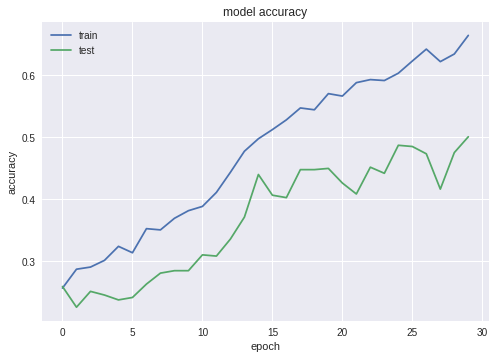

50/50 [==============================] - 0s 6ms/step
[0.9296763563156127, 0.56]
0.56


In [85]:
num_epochs = 30

# Create GRU model

# GRU uses less params than LSTM, for faster training
# Simple GRU model with stacked GRU layers (inspiration from NLP) - 3 layers, with dropout
# GRU layer accepts data in the form (samples, timesteps, features)

def make_GRU():
    # input is of the form: (sample, spatial, temporal)
    model = Sequential()
    model.add(Permute((2, 1), input_shape=(22, 200)))
    
    model.add(Conv1D(filters = 64, kernel_size = 25, activation = 'elu'))
    model.add(Dropout(0.4))
    model.add(Conv1D(filters = 64, kernel_size = 25, activation = 'elu'))
    model.add(Dropout(0.4))
    
    model.add(Permute((2, 1)))
    
    # GRU layers
    model.add(GRU(32, return_sequences=True))
    model.add(GRU(32, return_sequences=True))
    
    # Dense layers
    model.add(Flatten())
    model.add(Dense(units=4, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='SGD',
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

# make_GRU()
  
avg_acc = 0
for train_idx, test_idx in tt_splits:
    X_train = X[train_idx]
    y_train = y_cat[train_idx]
    X_test = X[test_idx]
    y_test = y_cat[test_idx]
    
    model = make_GRU()
    
    history = model.fit(X_train, y_train, validation_split=val_split, epochs=num_epochs, batch_size=batch_size)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    metrics = model.evaluate(X_test, y_test, batch_size=batch_size)
    avg_acc += metrics[1]
    print(metrics)
    break

print(avg_acc)

In [86]:
num_folds = 5
window_size = 100

# Get the data from one person
X, y = get_trial(1)
num_trials = 1

x_shape = X.shape
y_shape = y.shape

print(x_shape)

# generate sliding window data
X, y = generate_sliding_window(X, y, window_size)
print(X.shape)

# Get the data from all the people
# X, y = get_all_trials()
# num_trials = 9

# 0 mean and unit variance
temp = np.reshape(X, (X.shape[0], -1))
X = np.reshape(preprocessing.scale(temp), X.shape)

# Generate train/test split
y_cat = keras.utils.to_categorical(y, num_classes=4)
tt_splits = stratified_train_test_split(X, y, num_folds, num_trials)

print(tt_splits)

# The data for each trial is of the shape (288, 22, 1000)
#   There are 288 samples per trial (12 of each class per "run", 4 classes, 6 "runs" 
#                                   at different time periods of the day)
#   There are 22 electrodes from the EEG (represents spatial aspect of the signals)
#   There are 1000 time units (4 seconds of data, sampled at 250Hz). The first 250 units
#                                   are when no movement occurs (but the cue is heard) and
#                                   the next 750 units are when the movement occurs
# The labels for each trial belong in one of 4 classes
#   0 - left
#   1 - right
#   2 - foot
#   3 - tongue

# Set training params for NN
batch_size = 32
val_split = 0.2
num_epochs = 5

(288, 22, 1000)
(5472, 22, 100)
<generator object BaseShuffleSplit.split at 0x7f488a1de6d0>


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_7 (Permute)          (None, 100, 22)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 76, 64)            35264     
_________________________________________________________________
dropout_7 (Dropout)          (None, 76, 64)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 52, 64)            102464    
_________________________________________________________________
dropout_8 (Dropout)          (None, 52, 64)            0         
_________________________________________________________________
permute_8 (Permute)          (None, 64, 52)            0         
_________________________________________________________________
gru_7 (GRU)                  (None, 64, 32)            8160      
__________

4337/4337 [==============================] - 27s 6ms/step - loss: 1.3989 - acc: 0.2541 - val_loss: 1.3880 - val_acc: 0.2535
Epoch 2/30
4337/4337 [==============================] - 26s 6ms/step - loss: 1.3932 - acc: 0.2647 - val_loss: 1.3879 - val_acc: 0.2507
Epoch 3/30
4337/4337 [==============================] - 26s 6ms/step - loss: 1.3867 - acc: 0.2792 - val_loss: 1.3877 - val_acc: 0.2673
Epoch 4/30
1024/4337 [======>.......................] - ETA: 18s - loss: 1.3761 - acc: 0.2998

4337/4337 [==============================] - 26s 6ms/step - loss: 1.3798 - acc: 0.2961 - val_loss: 1.3866 - val_acc: 0.2581
Epoch 5/30
4337/4337 [==============================] - 26s 6ms/step - loss: 1.3785 - acc: 0.2845 - val_loss: 1.3854 - val_acc: 0.2654
Epoch 6/30
4337/4337 [==============================] - 26s 6ms/step - loss: 1.3698 - acc: 0.3014 - val_loss: 1.3898 - val_acc: 0.2479
Epoch 7/30
 864/4337 [====>.........................] - ETA: 19s - loss: 1.3648 - acc: 0.3310

4337/4337 [==============================] - 26s 6ms/step - loss: 1.3609 - acc: 0.3320 - val_loss: 1.3759 - val_acc: 0.2839
Epoch 8/30
4337/4337 [==============================] - 26s 6ms/step - loss: 1.3516 - acc: 0.3366 - val_loss: 1.3586 - val_acc: 0.3115
Epoch 9/30
4337/4337 [==============================] - 26s 6ms/step - loss: 1.3319 - acc: 0.3572 - val_loss: 1.3350 - val_acc: 0.3410
Epoch 10/30
 864/4337 [====>.........................] - ETA: 19s - loss: 1.3142 - acc: 0.3553

4337/4337 [==============================] - 26s 6ms/step - loss: 1.3050 - acc: 0.3703 - val_loss: 1.3281 - val_acc: 0.3429
Epoch 11/30
4337/4337 [==============================] - 26s 6ms/step - loss: 1.2675 - acc: 0.3989 - val_loss: 1.2497 - val_acc: 0.3982
Epoch 12/30
4337/4337 [==============================] - 26s 6ms/step - loss: 1.2336 - acc: 0.4293 - val_loss: 1.2138 - val_acc: 0.4249
Epoch 13/30
 832/4337 [====>.........................] - ETA: 19s - loss: 1.2074 - acc: 0.4207

4337/4337 [==============================] - 26s 6ms/step - loss: 1.2034 - acc: 0.4429 - val_loss: 1.2222 - val_acc: 0.3963
Epoch 14/30
4337/4337 [==============================] - 26s 6ms/step - loss: 1.1816 - acc: 0.4510 - val_loss: 1.1837 - val_acc: 0.4286
Epoch 15/30
4337/4337 [==============================] - 26s 6ms/step - loss: 1.1597 - acc: 0.4591 - val_loss: 1.2056 - val_acc: 0.4249
Epoch 16/30
 832/4337 [====>.........................] - ETA: 19s - loss: 1.1621 - acc: 0.4712

4337/4337 [==============================] - 26s 6ms/step - loss: 1.1419 - acc: 0.4676 - val_loss: 1.1391 - val_acc: 0.4618
Epoch 17/30
4337/4337 [==============================] - 26s 6ms/step - loss: 1.1307 - acc: 0.4900 - val_loss: 1.1417 - val_acc: 0.4553
Epoch 18/30
4337/4337 [==============================] - 26s 6ms/step - loss: 1.1151 - acc: 0.4861 - val_loss: 1.1168 - val_acc: 0.4765
Epoch 19/30
 832/4337 [====>.........................] - ETA: 19s - loss: 1.1069 - acc: 0.4964

4337/4337 [==============================] - 26s 6ms/step - loss: 1.0965 - acc: 0.4937 - val_loss: 1.1250 - val_acc: 0.4719
Epoch 20/30
4337/4337 [==============================] - 26s 6ms/step - loss: 1.0845 - acc: 0.5020 - val_loss: 1.1143 - val_acc: 0.4728
Epoch 21/30
4337/4337 [==============================] - 26s 6ms/step - loss: 1.0782 - acc: 0.5110 - val_loss: 1.0920 - val_acc: 0.4885
Epoch 22/30
 832/4337 [====>.........................] - ETA: 19s - loss: 1.0604 - acc: 0.5312

4337/4337 [==============================] - 26s 6ms/step - loss: 1.0613 - acc: 0.5188 - val_loss: 1.0855 - val_acc: 0.4986
Epoch 23/30
4337/4337 [==============================] - 26s 6ms/step - loss: 1.0632 - acc: 0.5188 - val_loss: 1.0982 - val_acc: 0.4986
Epoch 24/30
4337/4337 [==============================] - 26s 6ms/step - loss: 1.0488 - acc: 0.5257 - val_loss: 1.0843 - val_acc: 0.5014
Epoch 25/30
 832/4337 [====>.........................] - ETA: 19s - loss: 1.0430 - acc: 0.5072

4337/4337 [==============================] - 26s 6ms/step - loss: 1.0387 - acc: 0.5289 - val_loss: 1.1052 - val_acc: 0.5032
Epoch 26/30
4337/4337 [==============================] - 26s 6ms/step - loss: 1.0357 - acc: 0.5264 - val_loss: 1.0760 - val_acc: 0.4940
Epoch 27/30
4337/4337 [==============================] - 26s 6ms/step - loss: 1.0260 - acc: 0.5359 - val_loss: 1.0608 - val_acc: 0.5115
Epoch 28/30
 832/4337 [====>.........................] - ETA: 19s - loss: 0.9990 - acc: 0.5421

4337/4337 [==============================] - 26s 6ms/step - loss: 1.0149 - acc: 0.5423 - val_loss: 1.0697 - val_acc: 0.5005
Epoch 29/30
4337/4337 [==============================] - 26s 6ms/step - loss: 1.0201 - acc: 0.5474 - val_loss: 1.0658 - val_acc: 0.5180
Epoch 30/30
4337/4337 [==============================] - 26s 6ms/step - loss: 1.0064 - acc: 0.5585 - val_loss: 1.0647 - val_acc: 0.5189


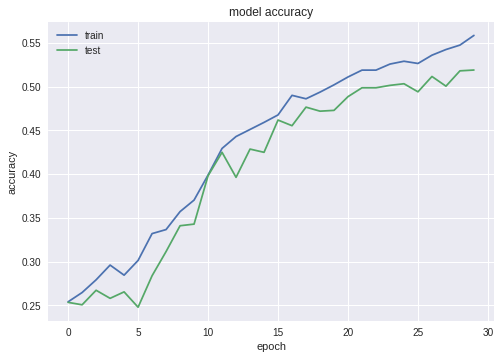

50/50 [==============================] - 0s 3ms/step
[1.3164552354812622, 0.4200000023841858]
0.4200000023841858


In [87]:
num_epochs = 30

# Create GRU model

# GRU uses less params than LSTM, for faster training
# Simple GRU model with stacked GRU layers (inspiration from NLP) - 3 layers, with dropout
# GRU layer accepts data in the form (samples, timesteps, features)

def make_GRU():
    # input is of the form: (sample, spatial, temporal)
    model = Sequential()
    model.add(Permute((2, 1), input_shape=(22, 100)))
    
    model.add(Conv1D(filters = 64, kernel_size = 25, activation = 'elu'))
    model.add(Dropout(0.4))
    model.add(Conv1D(filters = 64, kernel_size = 25, activation = 'elu'))
    model.add(Dropout(0.4))
    
    model.add(Permute((2, 1)))
    
    # GRU layers
    model.add(GRU(32, return_sequences=True))
    model.add(GRU(32, return_sequences=True))
    
    # Dense layers
    model.add(Flatten())
    model.add(Dense(units=4, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='SGD',
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

# make_GRU()
  
avg_acc = 0
for train_idx, test_idx in tt_splits:
    X_train = X[train_idx]
    y_train = y_cat[train_idx]
    X_test = X[test_idx]
    y_test = y_cat[test_idx]
    
    model = make_GRU()
    
    history = model.fit(X_train, y_train, validation_split=val_split, epochs=num_epochs, batch_size=batch_size)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    metrics = model.evaluate(X_test, y_test, batch_size=batch_size)
    avg_acc += metrics[1]
    print(metrics)
    break

print(avg_acc)

In [88]:
num_folds = 5
window_size = 50

# Get the data from one person
X, y = get_trial(1)
num_trials = 1

x_shape = X.shape
y_shape = y.shape

print(x_shape)

# generate sliding window data
X, y = generate_sliding_window(X, y, window_size)
print(X.shape)

# Get the data from all the people
# X, y = get_all_trials()
# num_trials = 9

# 0 mean and unit variancea
temp = np.reshape(X, (X.shape[0], -1))
X = np.reshape(preprocessing.scale(temp), X.shape)

# Generate train/test split
y_cat = keras.utils.to_categorical(y, num_classes=4)
tt_splits = stratified_train_test_split(X, y, num_folds, num_trials)

print(tt_splits)

# The data for each trial is of the shape (288, 22, 1000)
#   There are 288 samples per trial (12 of each class per "run", 4 classes, 6 "runs" 
#                                   at different time periods of the day)
#   There are 22 electrodes from the EEG (represents spatial aspect of the signals)
#   There are 1000 time units (4 seconds of data, sampled at 250Hz). The first 250 units
#                                   are when no movement occurs (but the cue is heard) and
#                                   the next 750 units are when the movement occurs
# The labels for each trial belong in one of 4 classes
#   0 - left
#   1 - right
#   2 - foot
#   3 - tongue

# Set training params for NN
batch_size = 32
val_split = 0.2
num_epochs = 5

(288, 22, 1000)
(11232, 22, 50)
<generator object BaseShuffleSplit.split at 0x7f4895cacd00>


In [0]:
num_epochs = 30

# Create GRU model

# GRU uses less params than LSTM, for faster training
# Simple GRU model with stacked GRU layers (inspiration from NLP) - 3 layers, with dropout
# GRU layer accepts data in the form (samples, timesteps, features)

def make_GRU():
    # input is of the form: (sample, spatial, temporal)
    model = Sequential()
    model.add(Permute((2, 1), input_shape=(22, 50)))
    
    model.add(Conv1D(filters = 64, kernel_size = 25, activation = 'elu'))
    model.add(Dropout(0.4))
    model.add(Conv1D(filters = 64, kernel_size = 25, activation = 'elu'))
    model.add(Dropout(0.4))
    
    model.add(Permute((2, 1)))
    
    # GRU layers
    model.add(GRU(32, return_sequences=True))
    model.add(GRU(32, return_sequences=True))
    
    # Dense layers
    model.add(Flatten())
    model.add(Dense(units=4, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='SGD',
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

# make_GRU()
  
avg_acc = 0
for train_idx, test_idx in tt_splits:
    X_train = X[train_idx]
    y_train = y_cat[train_idx]
    X_test = X[test_idx]
    y_test = y_cat[test_idx]
    
    model = make_GRU()
    
    history = model.fit(X_train, y_train, validation_split=val_split, epochs=num_epochs, batch_size=batch_size)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    metrics = model.evaluate(X_test, y_test, batch_size=batch_size)
    avg_acc += metrics[1]
    print(metrics)
    break

print(avg_acc)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_9 (Permute)          (None, 50, 22)            0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 26, 64)            35264     
_________________________________________________________________
dropout_9 (Dropout)          (None, 26, 64)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 2, 64)             102464    
_________________________________________________________________
dropout_10 (Dropout)         (None, 2, 64)             0         
_________________________________________________________________
permute_10 (Permute)         (None, 64, 2)             0         
_________________________________________________________________
gru_9 (GRU)                  (None, 64, 32)            3360      
__________

8945/8945 [==============================] - 55s 6ms/step - loss: 1.3879 - acc: 0.2445 - val_loss: 1.3876 - val_acc: 0.2365
Epoch 2/30
8945/8945 [==============================] - 54s 6ms/step - loss: 1.3868 - acc: 0.2580 - val_loss: 1.3877 - val_acc: 0.2512
Epoch 3/30
1824/8945 [=====>........................] - ETA: 41s - loss: 1.3856 - acc: 0.2643

8945/8945 [==============================] - 54s 6ms/step - loss: 1.3856 - acc: 0.2644 - val_loss: 1.3876 - val_acc: 0.2512
Epoch 4/30
8945/8945 [==============================] - 54s 6ms/step - loss: 1.3850 - acc: 0.2684 - val_loss: 1.3877 - val_acc: 0.2530
Epoch 5/30
1856/8945 [=====>........................] - ETA: 40s - loss: 1.3854 - acc: 0.2543

8945/8945 [==============================] - 54s 6ms/step - loss: 1.3845 - acc: 0.2683 - val_loss: 1.3877 - val_acc: 0.2570
Epoch 6/30
8945/8945 [==============================] - 54s 6ms/step - loss: 1.3838 - acc: 0.2770 - val_loss: 1.3871 - val_acc: 0.2512
Epoch 7/30
1888/8945 [=====>........................] - ETA: 40s - loss: 1.3838 - acc: 0.2802

8945/8945 [==============================] - 54s 6ms/step - loss: 1.3835 - acc: 0.2787 - val_loss: 1.3867 - val_acc: 0.2499
Epoch 8/30
8945/8945 [==============================] - 54s 6ms/step - loss: 1.3819 - acc: 0.2796 - val_loss: 1.3866 - val_acc: 0.2664
Epoch 9/30
1888/8945 [=====>........................] - ETA: 40s - loss: 1.3809 - acc: 0.2881

8945/8945 [==============================] - 54s 6ms/step - loss: 1.3810 - acc: 0.2826 - val_loss: 1.3858 - val_acc: 0.2660
Epoch 10/30
8945/8945 [==============================] - 54s 6ms/step - loss: 1.3791 - acc: 0.2868 - val_loss: 1.3867 - val_acc: 0.2606
Epoch 11/30
1824/8945 [=====>........................] - ETA: 40s - loss: 1.3793 - acc: 0.2867

8945/8945 [==============================] - 54s 6ms/step - loss: 1.3787 - acc: 0.2914 - val_loss: 1.3845 - val_acc: 0.2736
Epoch 12/30
8945/8945 [==============================] - 53s 6ms/step - loss: 1.3746 - acc: 0.2906 - val_loss: 1.3829 - val_acc: 0.2758
Epoch 13/30
1856/8945 [=====>........................] - ETA: 40s - loss: 1.3698 - acc: 0.3006

8945/8945 [==============================] - 54s 6ms/step - loss: 1.3710 - acc: 0.3067 - val_loss: 1.3819 - val_acc: 0.2883
Epoch 14/30
8945/8945 [==============================] - 54s 6ms/step - loss: 1.3665 - acc: 0.3096 - val_loss: 1.3737 - val_acc: 0.2852
Epoch 15/30
1856/8945 [=====>........................] - ETA: 39s - loss: 1.3574 - acc: 0.3163

8945/8945 [==============================] - 54s 6ms/step - loss: 1.3548 - acc: 0.3166 - val_loss: 1.3550 - val_acc: 0.3093
Epoch 16/30
8945/8945 [==============================] - 54s 6ms/step - loss: 1.3414 - acc: 0.3374 - val_loss: 1.3325 - val_acc: 0.3357
Epoch 17/30
1856/8945 [=====>........................] - ETA: 40s - loss: 1.3199 - acc: 0.3540

8945/8945 [==============================] - 54s 6ms/step - loss: 1.3162 - acc: 0.3574 - val_loss: 1.3455 - val_acc: 0.3281
Epoch 18/30
8945/8945 [==============================] - 54s 6ms/step - loss: 1.3068 - acc: 0.3636 - val_loss: 1.2999 - val_acc: 0.3675
Epoch 19/30
1856/8945 [=====>........................] - ETA: 40s - loss: 1.3019 - acc: 0.3836

8945/8945 [==============================] - 54s 6ms/step - loss: 1.2868 - acc: 0.3849 - val_loss: 1.2878 - val_acc: 0.3688
Epoch 20/30
8945/8945 [==============================] - 54s 6ms/step - loss: 1.2713 - acc: 0.3944 - val_loss: 1.2683 - val_acc: 0.3751
Epoch 21/30
1856/8945 [=====>........................] - ETA: 40s - loss: 1.2560 - acc: 0.4019

8945/8945 [==============================] - 54s 6ms/step - loss: 1.2603 - acc: 0.3973 - val_loss: 1.2483 - val_acc: 0.3996
Epoch 22/30
8945/8945 [==============================] - 54s 6ms/step - loss: 1.2425 - acc: 0.4080 - val_loss: 1.2616 - val_acc: 0.3871
Epoch 23/30
1856/8945 [=====>........................] - ETA: 40s - loss: 1.2407 - acc: 0.4030

8945/8945 [==============================] - 54s 6ms/step - loss: 1.2334 - acc: 0.4126 - val_loss: 1.2514 - val_acc: 0.3903
Epoch 24/30
8945/8945 [==============================] - 54s 6ms/step - loss: 1.2183 - acc: 0.4294 - val_loss: 1.2228 - val_acc: 0.4184
Epoch 25/30
1856/8945 [=====>........................] - ETA: 40s - loss: 1.2119 - acc: 0.4289

8945/8945 [==============================] - 56s 6ms/step - loss: 1.2063 - acc: 0.4304 - val_loss: 1.2291 - val_acc: 0.4157
Epoch 26/30
8945/8945 [==============================] - 54s 6ms/step - loss: 1.1970 - acc: 0.4396 - val_loss: 1.2156 - val_acc: 0.4309
Epoch 27/30
1824/8945 [=====>........................] - ETA: 40s - loss: 1.1786 - acc: 0.4523

8416/8945 [===========================>..] - ETA: 3s - loss: 1.1892 - acc: 0.4405